In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Importamos la data
spotify = pd.read_csv("../data/data_principal.csv")

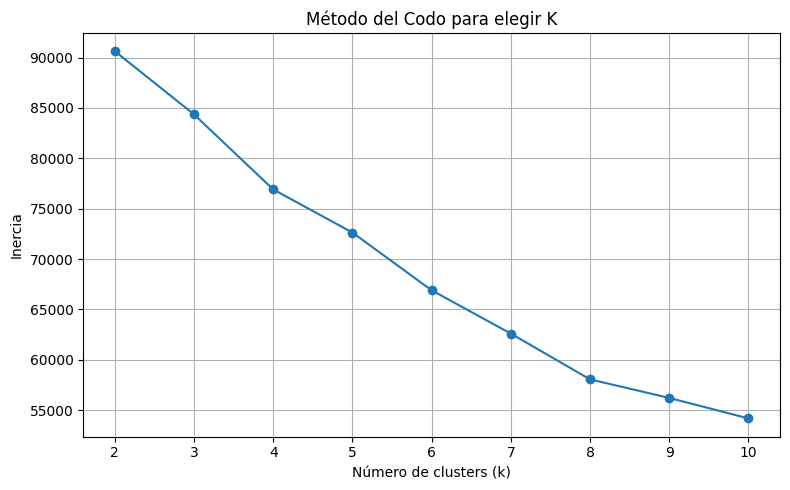

In [ ]:
# Columnas numéricas relevantes para clustering
numeric_cols = [
    'popularity', 'duration_ms', 'danceability', 'energy',
    'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo'
]

# Asegurarse de que los datos son numéricos y eliminar nulos
spotify[numeric_cols] = spotify[numeric_cols].apply(pd.to_numeric, errors='coerce')
df_clean = spotify.dropna(subset=numeric_cols)

# Muestreo aleatorio (escogemos 10.000 canciones aprox un 8% de la data)
df_sample = df_clean.sample(n=10000, random_state=42)

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sample[numeric_cols])

# Se calcula con el metodo del codo 
# la cantidad de clusters 
# "k" de menor inercia
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Graficar el codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Método del Codo para elegir K')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

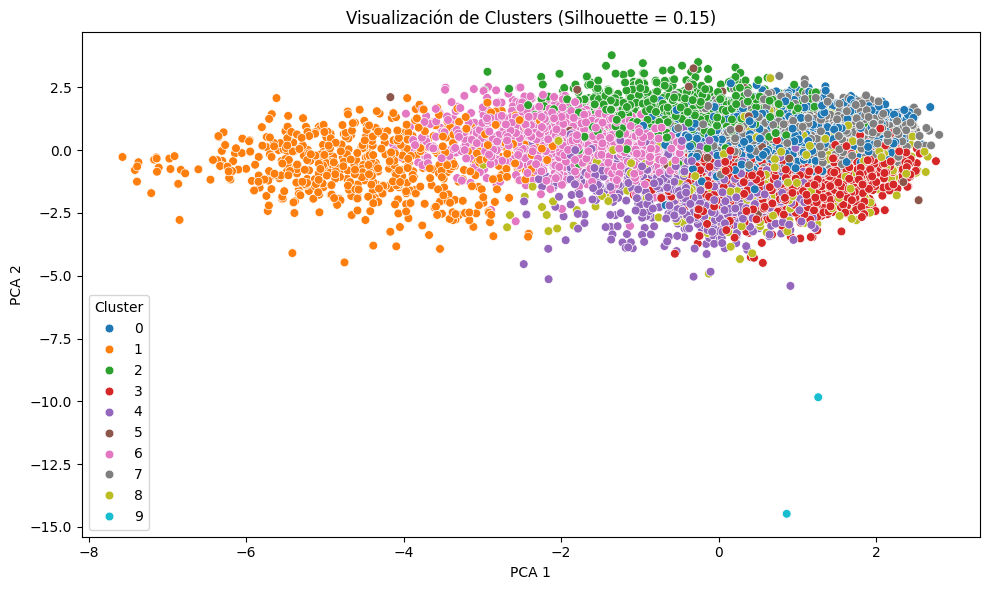

In [8]:
# Clustering con 10-Means
kmeans = KMeans(n_clusters=10, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(X_scaled)

# Evaluar calidad del clustering
score = silhouette_score(X_scaled, df_sample['cluster'])

# Reduccion de dimensionalidad
# Visualización en 2D con PCA (solo para graficar a 11 columnas)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Graficar clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=df_sample['cluster'], palette='tab10', s=40)
plt.title(f'Visualización de Clusters (Silhouette = {score:.2f})')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
# Agrupar por número de cluster y calcular promedio de cada variable numérica
cluster_summary = df_sample.groupby('cluster')[numeric_cols].mean()

# Redondear los valores para facilitar la lectura
cluster_summary_rounded = cluster_summary.round(2)

# Mostrar resumen
print("Resumen de características promedio por cluster:")
print(cluster_summary_rounded)

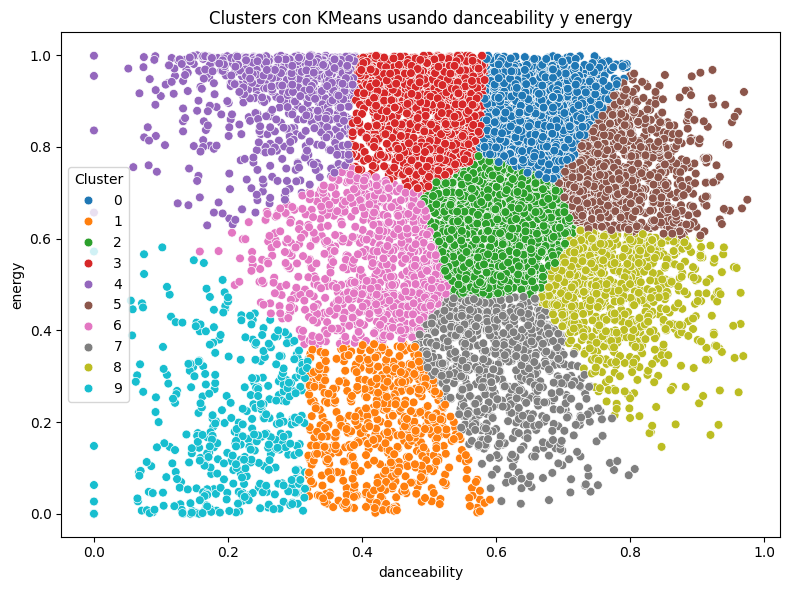

In [19]:
# Columnas a usar (solo 2)
# Consideraremos para el experimento las columas
# 'danceability' y 'energy'
selected_cols = ['danceability', 'energy']

# Asegurar datos numéricos
spotify[selected_cols] = spotify[selected_cols].apply(pd.to_numeric, errors='coerce')
df_clean = spotify.dropna(subset=selected_cols)
# Muestreo
df_sample = df_clean.sample(n=10000, random_state=42)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sample[selected_cols])

inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Clustering KMeans (puedes ajustar k)
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
df_sample['cluster'] = kmeans.fit_predict(X_scaled)

# Evaluación
score = silhouette_score(X_scaled, df_sample['cluster'])

# Visualización 
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_sample[selected_cols[0]],
    y=df_sample[selected_cols[1]],
    hue=df_sample['cluster'],
    palette='tab10',
    s=40
)
plt.title(f'Clusters con KMeans usando {selected_cols[0]} y {selected_cols[1]}')
plt.xlabel(selected_cols[0])
plt.ylabel(selected_cols[1])
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
# Agrupar por número de cluster y calcular promedio de cada variable numérica
cluster_summary = df_sample.groupby('cluster')[numeric_cols].mean()

# Redondear los valores para facilitar la lectura
cluster_summary_rounded = cluster_summary.round(2)

# Mostrar resumen
print("Resumen de características promedio por cluster:")
print(cluster_summary_rounded)

Silhouette Score: 0.07
Clusters encontrados (incluyendo ruido): 7


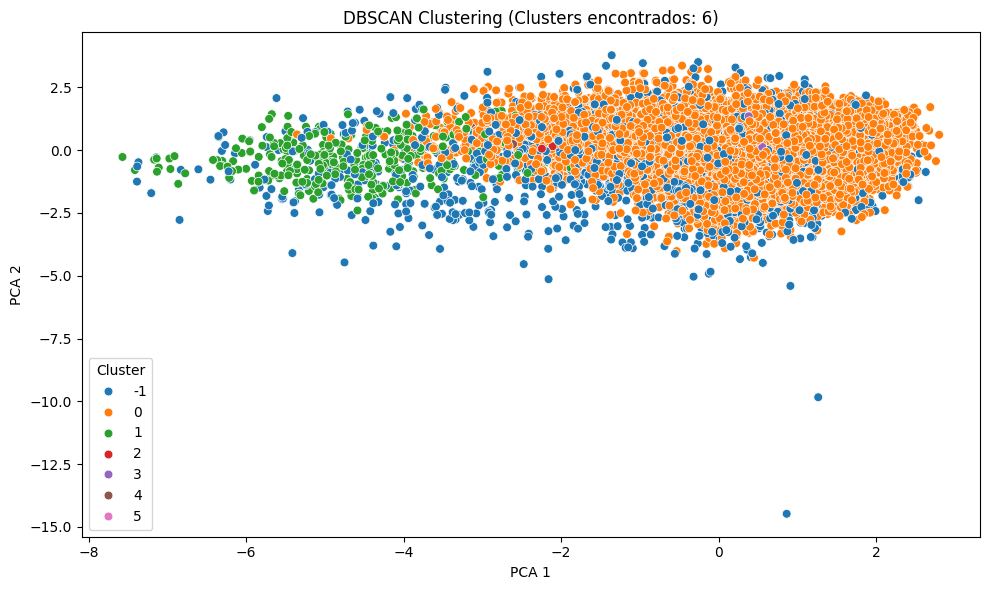

In [ ]:
# Clustering con DBSCAN
X_scaled = scaler.fit_transform(df_sample[numeric_cols])

dbscan = DBSCAN(eps=1.5, min_samples=10)
df_sample['cluster'] = dbscan.fit_predict(X_scaled)

# Evaluación (solo si hay más de 1 cluster válido)
n_clusters = len(set(df_sample['cluster'])) - (1 if -1 in df_sample['cluster'].unique() else 0)
if n_clusters > 1:
    score = silhouette_score(X_scaled, df_sample['cluster'])
    print(f"Silhouette Score: {score:.2f}")
else:
    print("No se puede calcular Silhouette Score (menos de 2 clusters encontrados)")

print(f"Clusters encontrados (incluyendo ruido): {df_sample['cluster'].nunique()}")

# Visualización con PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=df_sample['cluster'], palette='tab10', s=40)
plt.title(f'DBSCAN Clustering (Clusters encontrados: {n_clusters})')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [17]:
# Resumen por cluster (excluyendo ruido -1 si lo deseas)
cluster_summary = df_sample[df_sample['cluster'] != -1].groupby('cluster')[numeric_cols].mean().round(2)
print("\nResumen de características promedio por cluster:")
print(cluster_summary)


Resumen de características promedio por cluster:
         popularity  duration_ms  danceability  energy  loudness  speechiness  \
cluster                                                                         
0             33.59    223674.88          0.58    0.68     -7.08         0.07   
1             32.12    192888.86          0.38    0.15    -20.68         0.04   
2             19.57    142804.00          0.60    0.36    -12.08         0.06   
3             22.30    185082.00          0.56    0.77     -9.92         0.93   
4             45.40    121376.00          0.65    0.39    -12.24         0.07   
5             18.25    182112.75          0.64    0.52    -10.09         0.06   

         acousticness  instrumentalness  liveness  valence   tempo  
cluster                                                             
0                0.27              0.08      0.20     0.50  123.39  
1                0.92              0.88      0.12     0.18  105.52  
2                0.93    

Clusters encontrados (sin contar ruido): 1
No hay suficientes clusters para calcular Silhouette Score.


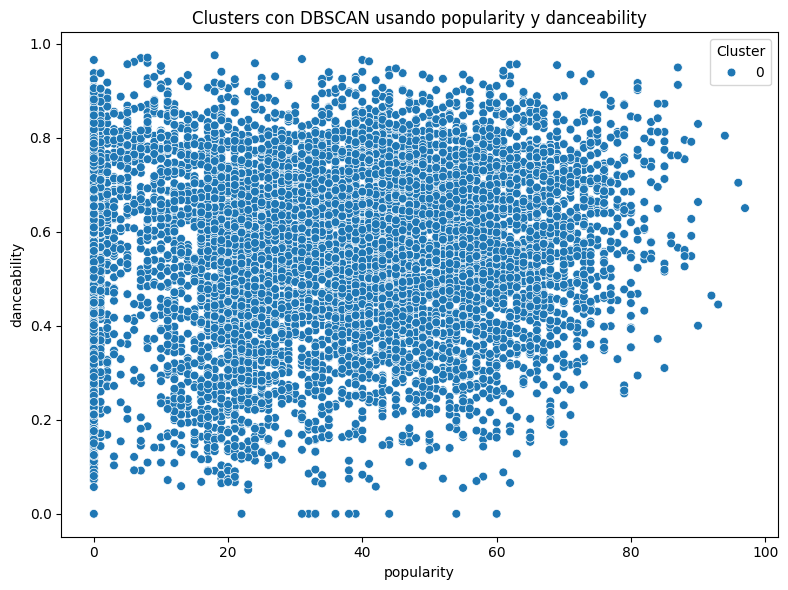

In [ ]:
# Seleccionar dos columnas para el análisis
selected_cols = ['popularity', 'danceability']

# Asegurar datos numéricos
spotify[selected_cols] = spotify[selected_cols].apply(pd.to_numeric, errors='coerce')
df_clean = spotify.dropna(subset=selected_cols)

# Muestreo
df_sample = df_clean.sample(n=10000, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sample[selected_cols])

# Prueba con eps más alto y min_samples más bajo
dbscan = DBSCAN(eps=0.7, min_samples=5)
df_sample['cluster'] = dbscan.fit_predict(X_scaled)

n_clusters = len(set(df_sample['cluster'])) - (1 if -1 in df_sample['cluster'] else 0)
print(f"Clusters encontrados (sin contar ruido): {n_clusters}")


# Silhouette Score (solo si hay más de un cluster válido)
if n_clusters > 1:
    score = silhouette_score(X_scaled[df_sample['cluster'] != -1],
                             df_sample['cluster'][df_sample['cluster'] != -1])
    print(f"Silhouette Score (sin ruido): {score:.2f}")
else:
    print("No hay suficientes clusters para calcular Silhouette Score.")


# Visualización sin PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_sample[selected_cols[0]],
    y=df_sample[selected_cols[1]],
    hue=df_sample['cluster'],
    palette='tab10',
    s=40
)
plt.title(f'Clusters con DBSCAN usando {selected_cols[0]} y {selected_cols[1]}')
plt.xlabel(selected_cols[0])
plt.ylabel(selected_cols[1])
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

